In [5]:
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en

Computer: server


In [110]:
#fucntions for handling and plotting
def decim(x, q):
    #decimate a 1 x n array
    #x: 1xn matrix (float)
    #q: int (decimate ratio), 0<q<=x.size
    assert(x.size>=q and q>0)
    pad_size = math.ceil(float(x.size)/q)*q - x.size
    pad = np.empty(pad_size)
    pad[:]=np.nan
    x_padded = np.append(x,pad)
    return sp.nanmean(x_padded.reshape(-1,q),axis=1)

def plot_raster(x, t1=0, t2=-1, t0=0, ax=None, bin_size=0):
    #plot a raster
    #x: spikes matrix:
        # nxt matrix with 1 where there is a spikes.
        # cols: time stamps (ms)
        # rows: trials
       
    #t1 from beggining of x to plot: default 0, dont cut
    #t2 time after begginning of x to plot: default -1, all range
    #t0 where to put the 0 (stimulus mark) relative to the range t1:t2
    #ax: axes object where to put the plot in (default = None, create a new one)
    #bin_size: int
    
    #Returns:
    # raster: a PathCollection (if bin_size=0) or a Line2D object (if bin_size=1)
    # ax    : Axes object 
    
    # Chop the segment
    if t2>0:
        assert(t2>t1)
        x = x[:,t1:t2]
    else:
        x = x[:,t1:]
            
    # get dimensions and time
    events   = x.shape[0]
    t_stamps = x.shape[1]
    t=np.arange(t_stamps)-t0
    
    #prepare the axis
    # if no axis, make a new plot
    if ax is None:
            raster_fig = plt.figure()
            ax = raster_fig.add_axes([0, 0, 1, 1])


    #pdb.set_trace()
    #if bin_size was entered, we want a psth
    if bin_size > 0:
        base_line = decim(np.mean(x[:t_stamps,:],axis=0), bin_size)/(0.001*bin_size)
        t_dec     = decim(t, bin_size);
        raster    = ax.plot(t_dec,base_line)
        
        ax.set_ylim(0, max(base_line)*1.2)
        stim   = ax.plot((0,0),(0,max(base_line)*1.2),'k--')
    
    else:
        #mask the zeros (no spike)
        nsp = x[:] == 0
        #x[nsp]=np.nan    
        
        
        #make the frame for plotting
        row = np.ones(t_stamps, dtype=np.float)
        col = np.arange(events, dtype=np.float)
        frame = col[:,np.newaxis] + row[np.newaxis,:]
        
        raster = ax.scatter(t*x,frame*x,marker='|')
        ax.set_ylim(0, events+1)
        stim   = ax.plot((0,0),(0,events+1),'k--')
        
    
    ax.set_xlim(0-t0,t_stamps-t0)
    
    return raster, ax

In [333]:
#functions for getting units
#Load a baseline sniff file
def load_sniff(mat_file_path):
    mat_file = os.path.join(mat_file_path)
    #print sio.whosmat(mat_file)
    base_data = sio.loadmat(mat_file,struct_as_record=False, squeeze_me=True)

    trialsBase = base_data['trialsBase']
    trialsBase.shape

    #print trialsBase[0].sniffFlow
    num_trials = trialsBase.shape[0]
    num_tpoints = trialsBase[0].sniffFlow.shape[0]
    #print num_trials

    sniff_flow = np.empty([num_tpoints, num_trials],dtype=int)
    sniff_phase = np.empty([num_tpoints, num_trials],dtype=int)
    sniff_start = np.empty([num_trials,1],dtype=int)
    #print sniff_flow.shape

    for i in range(num_trials):
        #print i
        tb=trialsBase[i]
        sniff_flow[:,i]  = tb.sniffFlow
        sniff_phase[:,i] = tb.sniffPhase[0:(num_tpoints)]
        sniff_start[i] = tb.start

    #print tb.sniffFlow.shape
    #print sniff_start
    #print tb['start'][0][0]
    #print tb['trialUId'][0]
    sniffs={'flow':sniff_flow, 'phase' : sniff_phase, 'start' : sniff_start}
    return sniffs

#Load a baseline raster file
def load_baseline(mat_file_path):

    base_data = sio.loadmat(mat_file,struct_as_record=False,squeeze_me = True)
    spikesBase = base_data['spikesBase']

    num_trials = spikesBase.spikes.shape[0]
    #print 'numtrials ' + str(num_trials)
    num_tpoints = spikesBase.spikes.shape[0]
    #print 'numpoints ' + str(num_tpoints)
    
    sr_spikes = np.array(spikesBase.spikes, dtype=np.float)
    sr_t0     = np.array(spikesBase.t0, dtype = np.float)
    
    return sr_spikes, sr_t0

#get a record from a matlab struct of a cell
def get_rec(rec):
    cell_data = rec.cell
    cell_odor_resp = { 'odors' : [ str(t) for t in rec.odors],
                      'trialId' : [ str(t) for t in rec.trialId],
                      'concs'   : [ t for t in rec.concs]
                     }
    #print cell_meta                  
    cell_meta ={'light'    : cell_data.light,
                'odor'     : cell_data.odor,
                'quality'  : cell_data.quality,
                'sessCell' : cell_data.sessCell,
                'mouse'    : str(cell_data.mouse),
                'sess'     : cell_data.sess,
                'rec'      : str(cell_data.rec),
                'u_id'     : str(cell_data.uId),
                'id'       : str(cell_data.Id),
                'comment'  : str(cell_data.comment)
                }

    record = {'meta'   : cell_meta,
              'odor'   : cell_odor_resp,
              'light'  : '',
              'rec_id' : cell_meta['mouse'] + '_' + str(cell_meta['sess']).zfill(3) + '_' + cell_meta['rec']
              }
    return record

#Load a record (cell file)
def load_cell(mat_file_path):
    cell_data = sio.loadmat(mat_file_path, struct_as_record=False, squeeze_me=True)

    records = []
    print type(cell_data['raster'])
    #print len(cell_data['raster'])
    #num_recs = len(cell_data['raster']) #num of recs the cell spans

    if type(cell_data['raster']) == np.ndarray:
        for rec in  cell_data['raster']:
            #print rec
            record = get_rec(rec)
            records.append(record)
    else:
        records.append(get_rec(cell_data['raster']))
    
    return records


(-500, 2500)

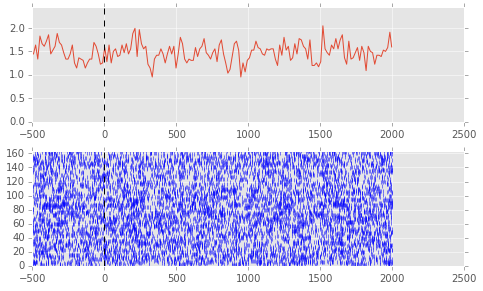

In [239]:
#load the sniff raster file
mat_file = os.path.join(fn.fold_exp_data,'KPawakeM72_019_002_spikesBase.mat')
sr_spikes, sr_t0 = load_baseline(mat_file)

#plot all the baseline sniffs
sr_plot = plt.figure()
ras_ax  = sr_plot.add_axes([0, 0, 1, .4])
hist_ax = sr_plot.add_axes([0, .5, 1, .4])
t0 = 500
t1 = 0
t2= 2500
bin_size=10

#plot the raster
lines,_ = plot_raster(sr_spikes,t0=t0,t1=t1,t2=t2,ax=ras_ax)
ras_ax.set_xlim(-500,2500)

#the psth
hist_line, hist_ax = plot_raster(sr_spikes,t0=t0, t1=t1,t2=t2, bin_size=15, ax=hist_ax)
#hist_ax.set_ylim(0.9,1.1)
hist_ax.set_xlim(-500,2500)

In [49]:
#get the units metadata

mat_file = os.path.join(fn.fold_exp_data,'unitsmeta.mat')
print sio.whosmat(mat_file)
cell_array = sio.loadmat(mat_file,struct_as_record=False)
print cell_array['cellsArray'].shape
n_cells = cell_array['cellsArray'].shape[1]
    cell_meta = {
        'uId'       : ["" for x in range(n_cells)],
        'quality'   : ,
        'light'     : cs.light,
        'odor'      : cs.odor,
        'sess_cell' : cs.sessCell,
        'clu'       : cs.clu,
        'rec'       : ["" for x in range(n_cells)],
        'mouse'     : ["" for x in range(n_cells)],
        'sess'      : cs.sess,
        'Id'        : ["" for x in range(n_cells)],
        'comment'   : ["" for x in range(n_cells)],
    }
for ic in range(n_cells):
    cs = cell_array['cellsArray'][0][ic]
    #print cs.comment


[('cellsArray', (1, 141), 'struct')]
(1, 141)
[u' ']
[u'probably sister of 4']
[u' ']
[u' ']
[u'inhibition and late resp to 2hydroxy']
[u' ']
[u' ']
[u' ']
[u'high spont activity']
[u'response to menthone']
[u'late to 2hydroxy, early to eti tiglate?']
[u' ']
[u' ']
[ u'response to strong ligands, not strong response to acetophenone, sister to 8; messy waveforms']
[ u'response to strong ligands, not strong response to acetophenone; small spk but tight clu']
[u'inhibitory to all; excitatory for menthone']
[u'resp to almost all']
[u' ']
[u'response to acetophenone']
[ u'good responses for 2-hydroxy, nothing for the rest; messy waveforms; looks same as h6']
[ u'good responses for 2-hydroxy, nothing for the rest; small spkie, but looks similar to h8']
[u'weak responses']
[u'early to 2,4 dimethyl than 2-hydroxy']
[u'response to 2-4-dimethyl later to 2hydroxy']
[u' ']
[u'a bit noisy. response to 2-hydroxy, acetophenone, maybe ethyl tiglate']
[ u'weird responses to odors (but 2-hydroxy comes f

In [334]:
# get all the cells
cells_path = fn.fold_exp_data
all_cells = [f for f in os.listdir(cells_path) if os.path.isfile(os.path.join(cells_path,f)) ]
unit_files = [f for f in all_cells if f.find('cell.mat')>0]
print unit_files


#get all the units
records = []
i_f = 0
for unit_file in unit_files:
    i_f+=1
    print i_f
    rec_file = os.path.join(cells_path,unit_file)
    unit_recs = load_cell(rec_file)
    records.append(unit_recs[:])


['KPawakeM72_019_002_cell.mat', 'ZKawakeM72_020_014_cell.mat', 'ZKawakeM72_020_022_cell.mat', 'ZKawakeM72_023_002_cell.mat', 'ZKawakeM72_023_003_cell.mat', 'ZKawakeM72_027_004_cell.mat', 'ZKawakeM72_027_005_cell.mat', 'KPawakeM72_021_001_cell.mat', 'KPawakeM72_817_001_cell.mat', 'ZKawakeM72_020_001_cell.mat', 'ZKawakeM72_022_001_cell.mat', 'KPawakeM72_014_001_cell.mat', 'KPawakeM72_014_004_cell.mat', 'KPawakeM72_014_006_cell.mat', 'KPawakeM72_014_007_cell.mat', 'KPawakeM72_014_012_cell.mat', 'ZKawakeM72_010_001_cell.mat', 'ZKawakeM72_010_002_cell.mat', 'ZKawakeM72_010_003_cell.mat', 'ZKawakeM72_010_004_cell.mat']
1
<class 'scipy.io.matlab.mio5_params.mat_struct'>
2
<class 'scipy.io.matlab.mio5_params.mat_struct'>
3
<class 'scipy.io.matlab.mio5_params.mat_struct'>
4
<class 'scipy.io.matlab.mio5_params.mat_struct'>
5
<class 'scipy.io.matlab.mio5_params.mat_struct'>
6
<type 'numpy.ndarray'>
7
<class 'scipy.io.matlab.mio5_params.mat_struct'>
8
<type 'numpy.ndarray'>
9
<type 'numpy.ndarray'

In [332]:
u_f = unit_files[-4]
#print u_f
rec_file = os.path.join(fn.fold_exp_data,u_f)
#records = load_cell(rec_file)
#print sio.whosmat(mat_file)
#print records

cell_data = sio.loadmat(rec_file, struct_as_record=False, squeeze_me=True)

records = []
print type(cell_data['raster'])
#print len(cell_data['raster'])
#num_recs = len(cell_data['raster']) #num of recs the cell spans

if type(cell_data['raster']) == np.ndarray:
    for rec in  cell_data['raster']:
        #print rec
        record = get_rec(rec)
        records.append(record)
else:
    records.append(get_rec(cell_data['raster']))
    
#records = load_cell(rec_file)

#print one_cell['uid']
#cell_data['raster'][0][1]['odors'].shape
records[0]

<type 'numpy.ndarray'>


{'light': '',
 'meta': {'comment': 'nice; response to 2hydroxy/ethyl; no resp to aceotph/menthone',
  'id': 'ZKawakeM72_010_b_001',
  'light': 1,
  'mouse': 'ZKawakeM72',
  'odor': 1,
  'quality': 1,
  'rec': 'b',
  'sess': 10,
  'sessCell': 1,
  'u_id': 'ZKawakeM72_010_001'},
 'odor': {'concs': [0.00023700000019744039,
   0.00013000000035390258,
   0.00079000002006068826,
   0.0051000001840293407,
   0.0051000001840293407,
   0.00013000000035390258,
   0.00079000002006068826,
   0.0015999999595806003,
   0.00079000002006068826,
   0.00013000000035390258,
   0.0051000001840293407,
   0.0015999999595806003,
   0.00013000000035390258,
   0.0015999999595806003,
   0.00079000002006068826,
   0.0051000001840293407,
   0.0015999999595806003,
   0.00013000000035390258,
   0.0051000001840293407,
   0.00079000002006068826,
   0.00013000000035390258,
   0.0015999999595806003,
   0.0051000001840293407,
   0.00079000002006068826,
   0.0015999999595806003,
   0.0051000001840293407,
   0.00079000002

In [336]:
records[10]

[{'light': '',
  'meta': {'comment': 'high modulation with sniff; early but lower response to higher conc',
   'id': 'ZKawakeM72_022_d_001',
   'light': 1,
   'mouse': 'ZKawakeM72',
   'odor': 1,
   'quality': 1,
   'rec': 'd',
   'sess': 22,
   'sessCell': 1,
   'u_id': 'ZKawakeM72_022_001'},
  'odor': {'concs': [3.8877300539752468e-05,
    0.001408000010997057,
    0.00040953001007437706,
    3.8877300539752468e-05,
    0.0051000001840293407,
    0.00040953001007437706,
    0.001408000010997057,
    0.0051000001840293407,
    3.8877300539752468e-05,
    3.8877300539752468e-05,
    0.001408000010997057,
    0.00040953001007437706,
    0.0051000001840293407,
    0.00040953001007437706,
    0.0051000001840293407,
    3.8877300539752468e-05,
    0.001408000010997057,
    0.00040953001007437706,
    3.8877300539752468e-05,
    0.0051000001840293407,
    0.001408000010997057,
    3.8877300539752468e-05,
    0.0051000001840293407,
    0.001408000010997057,
    0.00040953001007437706,
    0.

In [6]:
mouse = 'ZKawakeM72'
sess  = 27
rec   = 'a'
fn = en.file_names(mouse,sess,rec,root=experiment_folder)

In [9]:
# Load a unit array
# todo: complete
mat_file = os.path.join(fn.fold_exp_data,'ZKawakeM72_027_e_spikes.mat')
cell_data = sio.loadmat(mat_file)
print sio.whosmat(mat_file)
unit = cell_data['unit']
unit.shape
i=1
u = unit[0][0]
print u['uId']

[('unit', (1, 1), 'struct')]
[u'ZKawakeM72_027_004']
